In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
dataset_train = pd.read_csv('train_titanic.csv')
dataset_test = pd.read_csv('test_titanic.csv')

dataset_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def Preprocessing_data(dataset):
    
    #fill Age
    dataset['Age'].fillna(value=dataset['Age'].mean(), inplace=True)
    
    
    dataset['Fare'].fillna(value=dataset['Fare'].mean(), inplace=True)
    dataset['Embarked'].fillna('Q', inplace=True)
    

    
    dataset = dataset.drop(['PassengerId','Name','Cabin','Ticket'],axis=1)
    return dataset
    
dataset_train = Preprocessing_data(dataset_train)
dataset_test = Preprocessing_data(dataset_test)

In [4]:
def One_hot_columns(dataset):
    
    cat_cols = ['Sex','Embarked']
    cat_cols_encoded = []
    for col in cat_cols:
        cat_cols_encoded += sorted([cat for cat in list(dataset[col].unique())])
        
    
    oh_encoder = OneHotEncoder(sparse = False,handle_unknown='ignore')
    encoder_cols = oh_encoder.fit_transform(dataset[cat_cols])
    df_new = pd.DataFrame(encoder_cols,columns = cat_cols_encoded)
    datasetnew = dataset.join(df_new)
    
    datasetnew = datasetnew.drop(cat_cols,axis=1)
    
    return datasetnew

dataset_train = One_hot_columns(dataset_train)
dataset_test = One_hot_columns(dataset_test)

In [5]:
dataset_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [6]:
dataset_test.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,1.0,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,1.0


# Test model

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [8]:
def test_model(X_train, y_train, X_test, y_test, scaling):
    classifications = [['DecisionTreeClassifier',DecisionTreeClassifier()],
                        ['KNeighborsClassifier',KNeighborsClassifier()],
                        ['MLPClassifier',MLPClassifier(max_iter=500)]]
    Acc = pd.DataFrame(index=None,columns = ['Model', 'Accuracy','Scaling'])
    for mod in classifications:
        name = mod[0]
        model = mod[1]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        Acc = Acc.append(pd.Series({'Model':name,
                                   'Accuracy': accuracy_score(y_test,y_pred),
                                   'Scaling': scaling}), 
                                    ignore_index=True)
    return Acc

## no Scaling

In [13]:
df_test = pd.read_csv('gender_submission.csv')

In [14]:
X_train = dataset_train.iloc[:,1:].values
y_train = dataset_train.iloc[:,0].values
X_test = dataset_test.values
y_test = df_test.iloc[:,1].values

In [15]:
df1 = test_model(X_train, y_train, X_test, y_test,'No scaling')
df1

,Model,Accuracy,Scaling
0,DecisionTreeClassifier,0.775120,No scaling
1,KNeighborsClassifier,0.712919,No scaling
2,MLPClassifier,0.933014,No scaling


## Test model with Normalization

In [17]:
data_nor_train = dataset_train.copy()
data_nor_test = dataset_test.copy()
data_nor_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [19]:
MNScaler = MinMaxScaler().fit(data_nor_train[['Age','Fare']])
data_nor_train[['Age','Fare']] = MNScaler.transform(data_nor_train[['Age','Fare']])
data_nor_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,0.271174,1,0,0.014151,0.0,1.0,0.0,0.0,1.0
1,1,1,0.472229,1,0,0.139136,1.0,0.0,1.0,0.0,0.0
2,1,3,0.321438,0,0,0.015469,1.0,0.0,0.0,0.0,1.0
3,1,1,0.434531,1,0,0.103644,1.0,0.0,0.0,0.0,1.0
4,0,3,0.434531,0,0,0.015713,0.0,1.0,0.0,0.0,1.0


In [20]:
data_nor_test[['Age','Fare']] = MNScaler.transform(data_nor_test[['Age','Fare']])
data_nor_test.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,3,0.428248,0,0,0.015282,0.0,1.0,0.0,1.0,0.0
1,3,0.585323,1,0,0.013663,1.0,0.0,0.0,0.0,1.0
2,2,0.773813,0,0,0.018909,0.0,1.0,0.0,1.0,0.0
3,3,0.334004,0,0,0.016908,0.0,1.0,0.0,0.0,1.0
4,3,0.271174,1,1,0.023984,1.0,0.0,0.0,0.0,1.0


In [22]:
X_nor_train = data_nor_train.iloc[:,1:].values 
X_nor_test = data_nor_test.values

In [23]:
df2 = test_model(X_nor_train, y_train, X_nor_test,y_test, 'Normalization')
df2

c:\users\boot.ai\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Model,Accuracy,Scaling
0,DecisionTreeClassifier,0.765550,Normalization
1,KNeighborsClassifier,0.846890,Normalization
2,MLPClassifier,0.873206,Normalization


## test model with Standardization

In [24]:
data_stand_train = dataset_train.copy()
data_stand_test = dataset_test.copy()
data_stand_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [28]:
standardScaler = StandardScaler().fit(data_stand_train[['Age','Fare']])
data_stand_train[['Age','Fare']] = standardScaler.transform(data_stand_train[['Age','Fare']])
data_stand_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,-0.592481,1,0,-0.502445,0.0,1.0,0.0,0.0,1.0
1,1,1,0.638789,1,0,0.786845,1.0,0.0,1.0,0.0,0.0
2,1,3,-0.284663,0,0,-0.488854,1.0,0.0,0.0,0.0,1.0
3,1,1,0.407926,1,0,0.420730,1.0,0.0,0.0,0.0,1.0
4,0,3,0.407926,0,0,-0.486337,0.0,1.0,0.0,0.0,1.0


In [29]:
data_stand_test[['Age','Fare']] = standardScaler.transform(data_stand_test[['Age','Fare']])
data_stand_test.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,1.0,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,1.0


In [30]:
X_stand_train = data_stand_train.iloc[:,1:].values
X_stand_test = data_stand_test.values

In [31]:
df3 = test_model(X_stand_train, y_train, X_stand_test, y_test, 'Standardization')
df3

c:\users\boot.ai\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Model,Accuracy,Scaling
0,DecisionTreeClassifier,0.811005,Standardization
1,KNeighborsClassifier,0.590909,Standardization
2,MLPClassifier,0.366029,Standardization


In [32]:
df_ac = pd.concat([df1,df3,df2])
print(df_ac)

                    Model  Accuracy          Scaling
0  DecisionTreeClassifier  0.775120       No scaling
1    KNeighborsClassifier  0.712919       No scaling
2           MLPClassifier  0.933014       No scaling
0  DecisionTreeClassifier  0.811005  Standardization
1    KNeighborsClassifier  0.590909  Standardization
2           MLPClassifier  0.366029  Standardization
0  DecisionTreeClassifier  0.765550    Normalization
1    KNeighborsClassifier  0.846890    Normalization
2           MLPClassifier  0.873206    Normalization


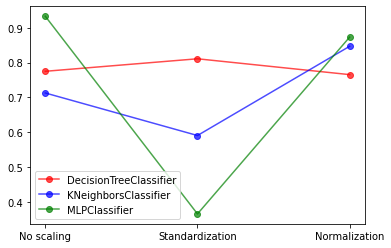

In [33]:
cdict = {'DecisionTreeClassifier':'red', 'KNeighborsClassifier':'blue', 'MLPClassifier': 'green'}
fig, ax =  plt.subplots()

for model in cdict.keys():
    df=df_ac[df_ac['Model']==model]
    plt.plot(df['Scaling'],df['Accuracy'],c=cdict[model],label=model, marker='o', alpha = 0.7)
plt.legend()
plt.show()